c:\Users\hari7\qiskit_new_env2\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.5
Confusion Matrix:
 [[1 1]
 [1 1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



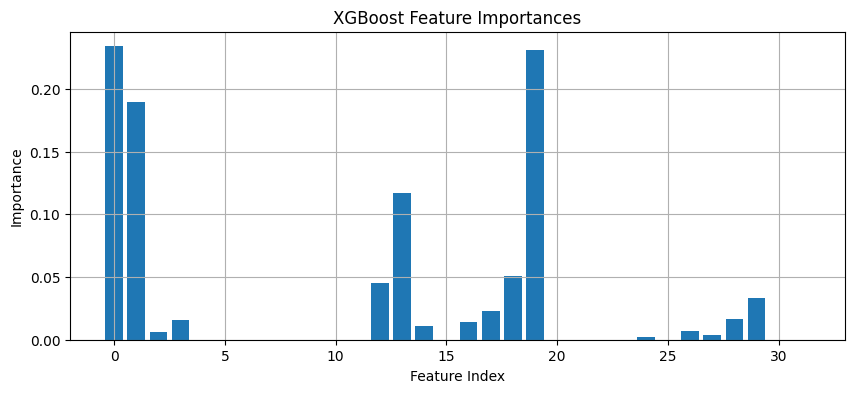

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# ========= CONFIG =========
EEG_DIR = r""
LABEL_FILE = r""
fs = 128  # Hz
# ==========================

# -------- Filters --------
def bandpass_filter(data, lowcut=0.5, highcut=45, fs=128, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, notch_freq=50.0, fs=128, quality=30.0):
    b, a = iirnotch(notch_freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

# -------- Hjorth Parameters --------
def hjorth_params(signal):
    first_deriv = np.diff(signal, axis=0)
    second_deriv = np.diff(first_deriv, axis=0)
    var_zero = np.var(signal, axis=0)
    var_d1 = np.var(first_deriv, axis=0)
    var_d2 = np.var(second_deriv, axis=0)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return activity, mobility, complexity

# -------- Feature Extraction --------
def extract_features(eeg):
    mean = np.mean(eeg, axis=0)
    std = np.std(eeg, axis=0)
    var = np.var(eeg, axis=0)
    min_ = np.min(eeg, axis=0)
    max_ = np.max(eeg, axis=0)
    activity, mobility, complexity = hjorth_params(eeg)

    features = np.concatenate([mean, std, var, min_, max_, activity, mobility, complexity])
    return features

# -------- Main Pipeline --------
label_df = pd.read_excel(LABEL_FILE, sheet_name="Sayfa1")
all_features = []
all_labels = []

for filename in os.listdir(EEG_DIR):
    if not filename.endswith(".csv"):
        continue

    filepath = os.path.join(EEG_DIR, filename)
    eeg_df = pd.read_csv(filepath)
    subject_id, session_id = filename[:2], filename[2:4]

    # Get label from Excel
    match = label_df[(label_df["SUBJECT"] == subject_id) & (label_df["SESSION"] == session_id)]
    if match.empty:
        continue
    label = int(match.iloc[0]["LIE/TRUTH"])

    # Preprocess
    eeg = eeg_df.iloc[:, 1:].values  # Assuming EEG channels are from 2nd column onward
    eeg = bandpass_filter(eeg, fs=fs)
    eeg = notch_filter(eeg, fs=fs)
    eeg = StandardScaler().fit_transform(eeg)

    # Feature extraction
    features = extract_features(eeg)
    all_features.append(features)
    all_labels.append(label)

# -------- Train XGBoost --------
X = np.array(all_features)
y = np.array(all_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Feature importance plot
model.get_booster().feature_names = [f'f{i}' for i in range(X.shape[1])]
model.get_booster().feature_names
model.get_booster().feature_types
model.get_booster().feature_importance = model.feature_importances_

plt.figure(figsize=(10, 4))
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.grid(True)
plt.show()


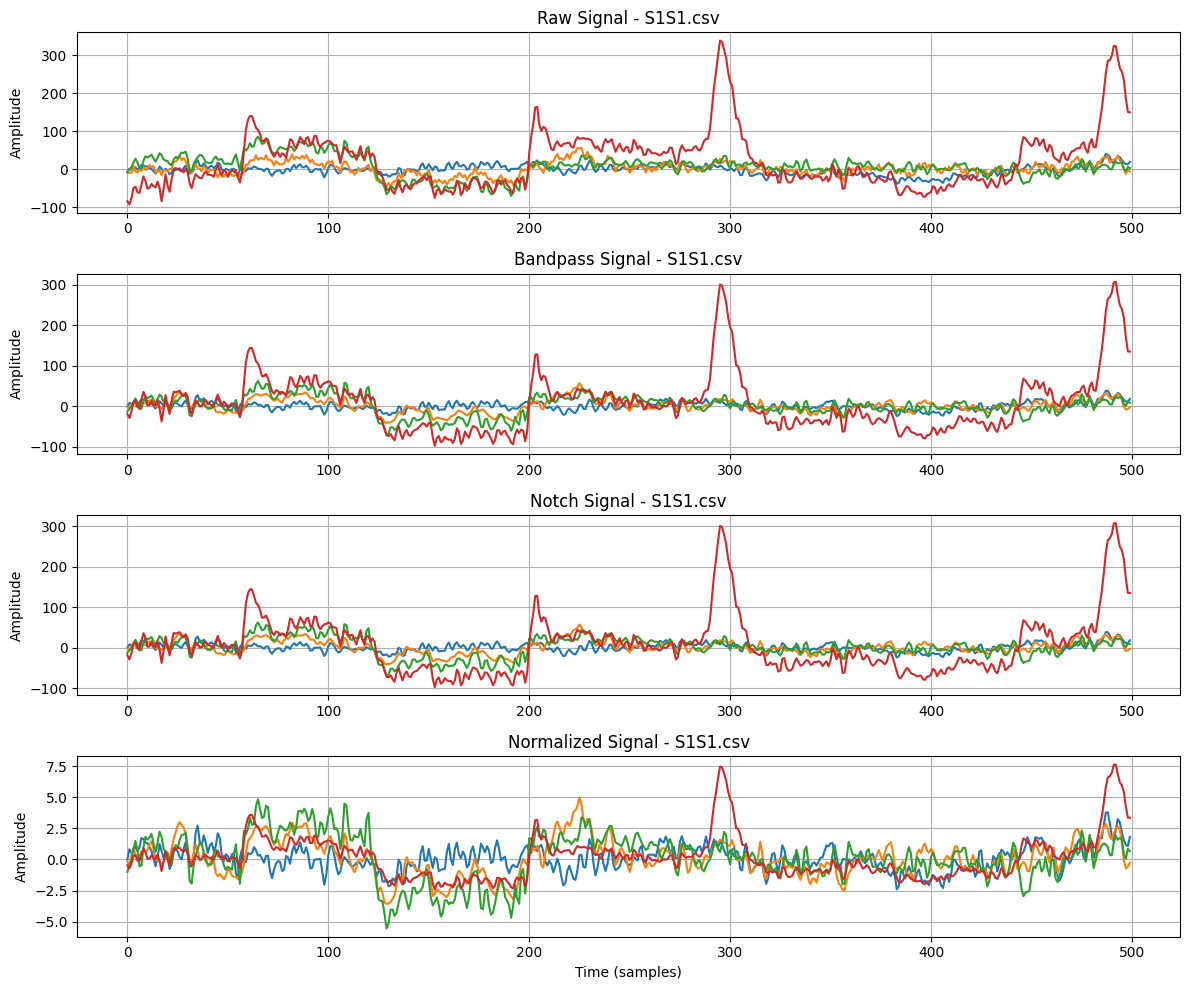


Accuracy: 0.5

Confusion Matrix:
 [[1 1]
 [1 1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



c:\Users\hari7\qiskit_new_env2\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


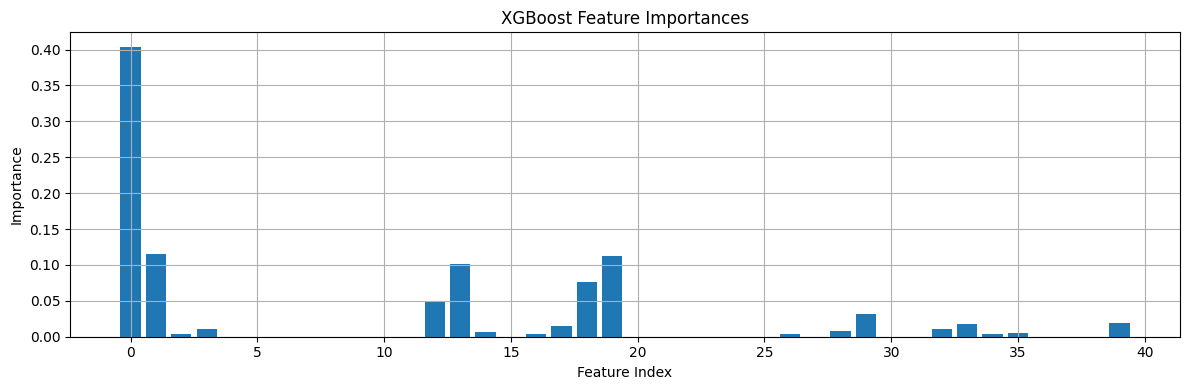

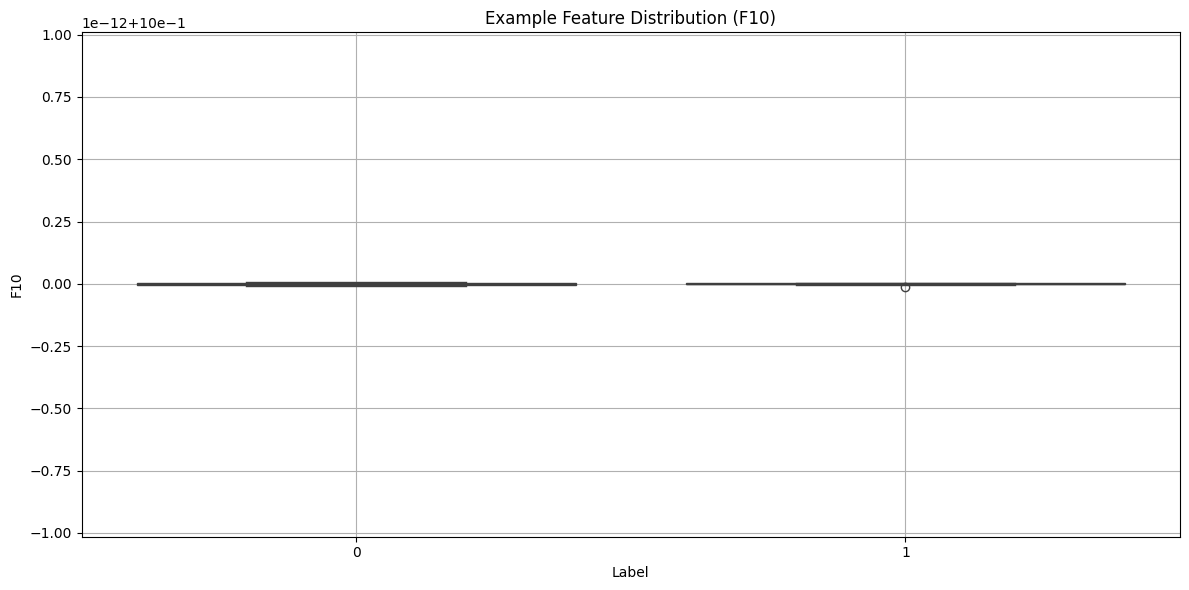

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import entropy

# ========== CONFIG ================
EEG_DIR = r""
LABEL_FILE = r""
fs = 128  # Hz
sample_plot = True  # Toggle to plot signal from the first file
# ==================================

# ------- Filters ----------
def bandpass_filter(data, lowcut=0.5, highcut=45, fs=128, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, notch_freq=50, fs=128, Q=30.0):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

# ------- Hjorth Parameters --------
def hjorth_params(signal):
    first = np.diff(signal, axis=0)
    second = np.diff(first, axis=0)
    var0 = np.var(signal, axis=0)
    var1 = np.var(first, axis=0)
    var2 = np.var(second, axis=0)
    activity = var0
    mobility = np.sqrt(var1 / var0)
    complexity = np.sqrt(var2 / var1) / mobility
    return activity, mobility, complexity

# ------- Other Time/Nonlinear Features ----------
def zero_crossings(signal):
    return np.array([(np.diff(np.sign(s)) != 0).sum() for s in signal.T])

def signal_entropy(signal):
    return np.array([entropy(np.histogram(s, bins=32, density=True)[0] + 1e-8) for s in signal.T])

# ------- Feature Extraction --------
def extract_features(eeg):
    mean = np.mean(eeg, axis=0)
    std = np.std(eeg, axis=0)
    var = np.var(eeg, axis=0)
    min_ = np.min(eeg, axis=0)
    max_ = np.max(eeg, axis=0)
    activity, mobility, complexity = hjorth_params(eeg)
    zcr = zero_crossings(eeg)
    ent = signal_entropy(eeg)

    return np.concatenate([mean, std, var, min_, max_, activity, mobility, complexity, zcr, ent])

# ------- Preprocessing Visualization --------
def plot_signal_steps(raw, band, notch, norm, title):
    plt.figure(figsize=(12, 10))
    for i, (data, label) in enumerate(zip([raw, band, notch, norm],
                                          ["Raw", "Bandpass", "Notch", "Normalized"])):
        plt.subplot(4, 1, i+1)
        plt.plot(data[:500])
        plt.title(f"{label} Signal - {title}")
        plt.ylabel("Amplitude")
        plt.grid(True)
    plt.xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

# ------- Main Pipeline --------
label_df = pd.read_excel(LABEL_FILE, sheet_name="Sayfa1")
features_list, labels_list = [], []
first_file_done = False

for file in os.listdir(EEG_DIR):
    if not file.endswith(".csv"):
        continue

    subject_id, session_id = file[:2], file[2:4]
    match = label_df[(label_df["SUBJECT"] == subject_id) & (label_df["SESSION"] == session_id)]
    if match.empty:
        continue
    label = int(match.iloc[0]["LIE/TRUTH"])

    eeg_df = pd.read_csv(os.path.join(EEG_DIR, file))
    eeg = eeg_df.iloc[:, 1:].values  # exclude timestamp

    raw = eeg.copy()
    band = bandpass_filter(raw, fs=fs)
    notch = notch_filter(band, fs=fs)
    norm = StandardScaler().fit_transform(notch)

    if sample_plot and not first_file_done:
        plot_signal_steps(raw, band, notch, norm, title=file)
        first_file_done = True

    feat = extract_features(norm)
    features_list.append(feat)
    labels_list.append(label)

# ------- Train & Evaluate XGBoost --------
X = np.array(features_list)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ------- Feature Importance --------
plt.figure(figsize=(12, 4))
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------- Feature Distribution (Optional) --------
df_feat = pd.DataFrame(X, columns=[f"F{i}" for i in range(X.shape[1])])
df_feat['Label'] = y
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_feat, x="Label", y="F10")  # Choose F10 or others to visualize
plt.title("Example Feature Distribution (F10)")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signa


Total segments: 666 | Features per segment: 1312
Total labels: 666
Files used: 18


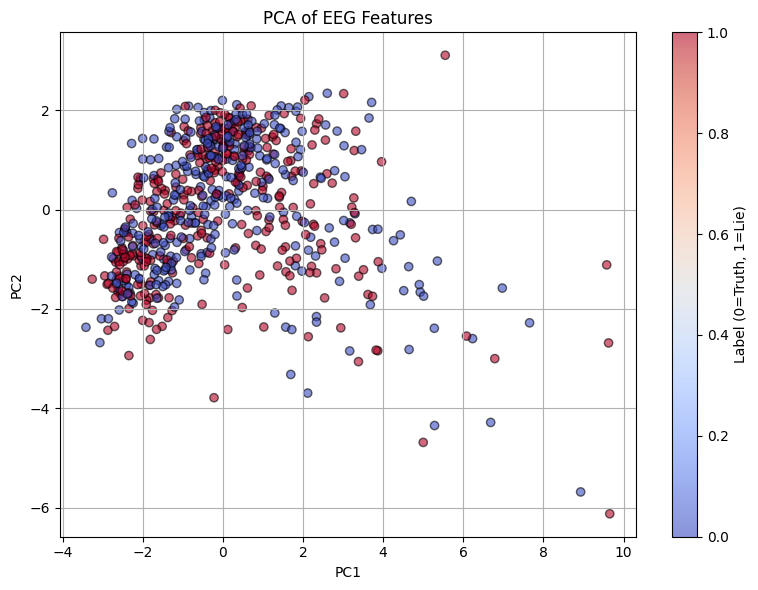

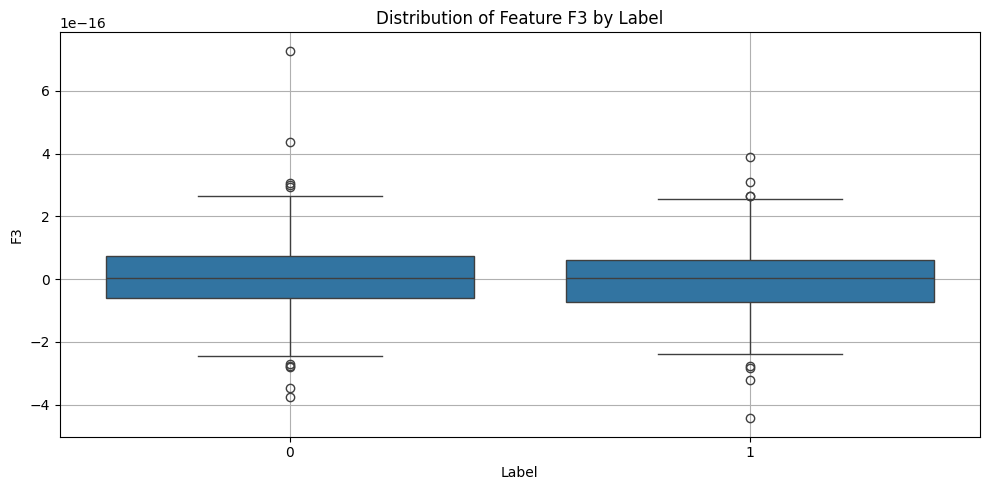

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch, welch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ---------- Configuration ----------
EEG_DIR = r""
LABEL_FILE = r""
fs = 128  # Sampling rate
win_size = 256  # 2 seconds
step_size = 256
# -----------------------------------

# ---------- EEG Filters ----------
def bandpass_filter(data, lowcut=0.5, highcut=45, fs=128, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, notch_freq=50.0, fs=128, Q=30.0):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

# ---------- Hjorth Parameters ----------
def hjorth_params(sig):
    first = np.diff(sig, axis=0)
    second = np.diff(first, axis=0)
    var0 = np.var(sig, axis=0)
    var1 = np.var(first, axis=0)
    var2 = np.var(second, axis=0)
    activity = var0
    mobility = np.sqrt(var1 / var0)
    complexity = np.sqrt(var2 / var1) / mobility
    return activity, mobility, complexity

# ---------- Bandpower using Welch ----------
EEG_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 45)
}

def bandpower(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=sf*2)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    bp = np.sum(psd[:, idx], axis=1)
    return bp

# ---------- Segment and Feature Extraction ----------
def extract_features(eeg):
    mean = np.mean(eeg, axis=0)
    std = np.std(eeg, axis=0)
    var = np.var(eeg, axis=0)
    min_ = np.min(eeg, axis=0)
    max_ = np.max(eeg, axis=0)
    activity, mobility, complexity = hjorth_params(eeg)
    freq_feats = []
    for band in EEG_BANDS.values():
        freq_feats.append(bandpower(eeg, fs, band))
    freq_feats = np.concatenate(freq_feats)
    return np.concatenate([mean, std, var, min_, max_, activity, mobility, complexity, freq_feats])

def segment_eeg(eeg, label):
    segments = []
    labels = []
    for start in range(0, eeg.shape[0] - win_size + 1, step_size):
        win = eeg[start:start + win_size]
        win = StandardScaler().fit_transform(win)
        feat = extract_features(win)
        segments.append(feat)
        labels.append(label)
    return segments, labels

# ---------- Main Pipeline ----------
label_df = pd.read_excel(LABEL_FILE, sheet_name="Sayfa1")
X, y = [], []
files_used = 0

for file in os.listdir(EEG_DIR):
    if not file.endswith(".csv"):
        continue
    subject_id = file[:2]
    session_id = file[2:4]

    match = label_df[(label_df["SUBJECT"] == subject_id) & (label_df["SESSION"] == session_id)]
    if match.empty:
        continue
    label = int(match.iloc[0]["LIE/TRUTH"])
    
    df = pd.read_csv(os.path.join(EEG_DIR, file))
    eeg = df.iloc[:, 1:].values
    eeg = bandpass_filter(eeg)
    eeg = notch_filter(eeg)

    seg_X, seg_y = segment_eeg(eeg, label)
    X.extend(seg_X)
    y.extend(seg_y)
    files_used += 1

# ---------- Save Features ----------
X = np.array(X)
y = np.array(y)

print(f"\nTotal segments: {X.shape[0]} | Features per segment: {X.shape[1]}")
print(f"Total labels: {y.shape[0]}")
print(f"Files used: {files_used}")

np.save("eeg_features.npy", X)
np.save("eeg_labels.npy", y)

# ---------- Visualize Features ----------
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k')
plt.title("PCA of EEG Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Label (0=Truth, 1=Lie)")
plt.tight_layout()
plt.show()

# Boxplot of 1 feature
df_feat = pd.DataFrame(X, columns=[f'F{i}' for i in range(X.shape[1])])
df_feat['Label'] = y
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_feat, x='Label', y='F3')  # Change F3 to inspect other features
plt.title("Distribution of Feature F3 by Label")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signa


✅ Saved Time Features to: C:\Users\hari7\Documents\Semester 3\Microcrendential\BCI\Deception detection\Features\time_features.npy
✅ Saved Frequency Features to: C:\Users\hari7\Documents\Semester 3\Microcrendential\BCI\Deception detection\Features\freq_features.npy
✅ Saved Labels to: C:\Users\hari7\Documents\Semester 3\Microcrendential\BCI\Deception detection\Features\labels.npy

Files Processed: 18
Total Samples: 666


c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\hari7\qiskit_new_env2\Lib\site-packages\scipy\signa

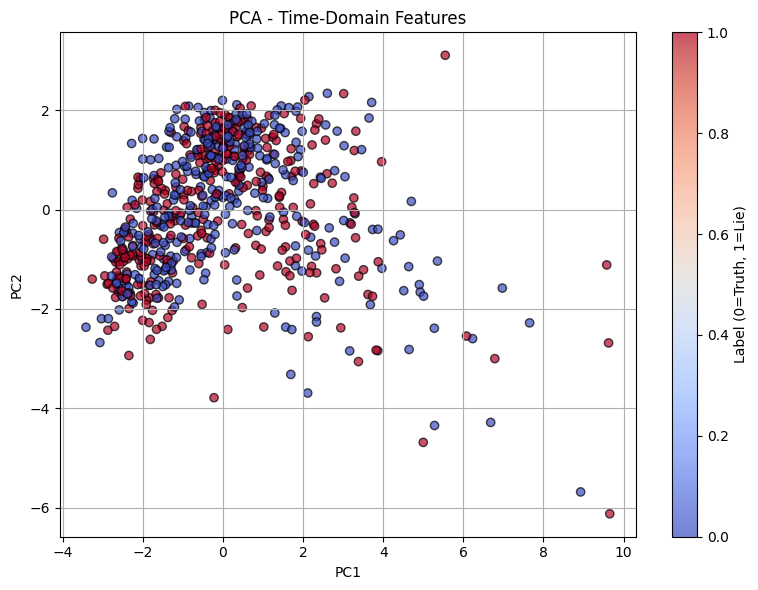

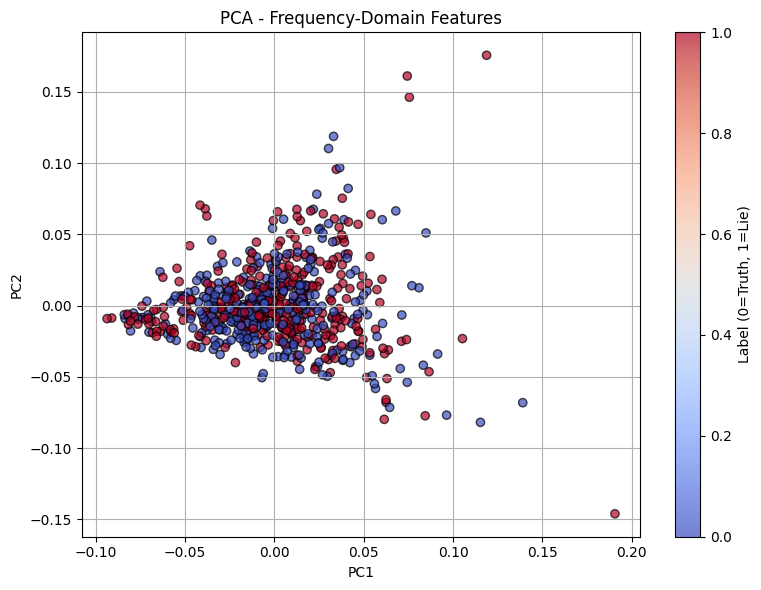

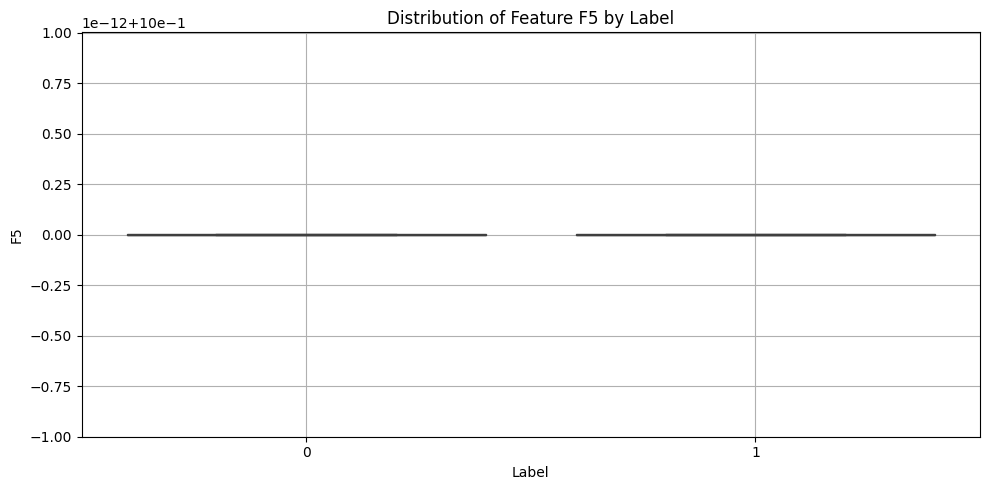

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch, welch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ------------------- CONFIG --------------------
EEG_DIR = r""
LABEL_FILE = r""
SAVE_DIR = r""
fs = 128  # Sampling rate in Hz
win_size = 256  # 2 seconds
step_size = 256  # no overlap
# ------------------------------------------------

os.makedirs(SAVE_DIR, exist_ok=True)

# ------------------ Filters ---------------------
def bandpass_filter(data, lowcut=0.5, highcut=45, fs=128, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, notch_freq=50.0, fs=128, quality=30.0):
    b, a = iirnotch(notch_freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

# ---------------- Hjorth Parameters ----------------
def hjorth_params(signal):
    first_deriv = np.diff(signal, axis=0)
    second_deriv = np.diff(first_deriv, axis=0)
    var_zero = np.var(signal, axis=0)
    var_d1 = np.var(first_deriv, axis=0)
    var_d2 = np.var(second_deriv, axis=0)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return activity, mobility, complexity

# ---------------- Frequency Bands ----------------
EEG_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 45)
}

def bandpower(data, sf, band):
    freqs, psd = welch(data, sf, nperseg=sf*2)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    bp = np.sum(psd[:, idx], axis=1)
    return bp  # One value per channel

# ---------------- Feature Extraction ----------------
def extract_time_features(eeg):
    mean = np.mean(eeg, axis=0)
    std = np.std(eeg, axis=0)
    var = np.var(eeg, axis=0)
    min_ = np.min(eeg, axis=0)
    max_ = np.max(eeg, axis=0)
    activity, mobility, complexity = hjorth_params(eeg)
    return np.concatenate([mean, std, var, min_, max_, activity, mobility, complexity])

def extract_freq_features(eeg):
    feats = []
    for band in EEG_BANDS.values():
        feats.append(bandpower(eeg, fs, band))
    return np.concatenate(feats)

def segment_eeg(eeg, label):
    t_feats, f_feats, labels = [], [], []
    for start in range(0, eeg.shape[0] - win_size + 1, step_size):
        window = eeg[start:start + win_size]
        window = StandardScaler().fit_transform(window)
        t_feat = extract_time_features(window)
        f_feat = extract_freq_features(window)
        t_feats.append(t_feat)
        f_feats.append(f_feat)
        labels.append(label)
    return t_feats, f_feats, labels

# ---------------- Main Pipeline ----------------
label_df = pd.read_excel(LABEL_FILE, sheet_name="Sayfa1")
all_time_features, all_freq_features, all_labels = [], [], []
files_used = 0

for file in os.listdir(EEG_DIR):
    if not file.endswith(".csv"):
        continue

    subject_id = file[:2]
    session_id = file[2:4]
    match = label_df[(label_df["SUBJECT"] == subject_id) & (label_df["SESSION"] == session_id)]
    if match.empty:
        continue

    label = int(match.iloc[0]["LIE/TRUTH"])
    df = pd.read_csv(os.path.join(EEG_DIR, file))
    eeg = df.iloc[:, 1:].values

    eeg = bandpass_filter(eeg)
    eeg = notch_filter(eeg)

    t_feat, f_feat, labels = segment_eeg(eeg, label)
    all_time_features.extend(t_feat)
    all_freq_features.extend(f_feat)
    all_labels.extend(labels)
    files_used += 1

# ---------------- Save Features ----------------
time_feat_path = os.path.join(SAVE_DIR, "time_features.npy")
freq_feat_path = os.path.join(SAVE_DIR, "freq_features.npy")
labels_path = os.path.join(SAVE_DIR, "labels.npy")

np.save(time_feat_path, np.array(all_time_features))
np.save(freq_feat_path, np.array(all_freq_features))
np.save(labels_path, np.array(all_labels))

print(f"\n✅ Saved Time Features to: {time_feat_path}")
print(f"✅ Saved Frequency Features to: {freq_feat_path}")
print(f"✅ Saved Labels to: {labels_path}")
print(f"\nFiles Processed: {files_used}")
print(f"Total Samples: {len(all_labels)}")

# ---------------- Visualize PCA ----------------
def visualize_pca(features, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
    plt.title(f'PCA - {title}')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Label (0=Truth, 1=Lie)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_pca(np.array(all_time_features), np.array(all_labels), "Time-Domain Features")
visualize_pca(np.array(all_freq_features), np.array(all_labels), "Frequency-Domain Features")

# ---------------- Boxplot of One Feature ----------------
df_plot = pd.DataFrame(np.array(all_time_features), columns=[f'F{i}' for i in range(len(all_time_features[0]))])
df_plot["Label"] = all_labels

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x="Label", y="F5")
plt.title("Distribution of Feature F5 by Label")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Accuracy: 54.48 %

Confusion Matrix:
 [[34 33]
 [28 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.51      0.53        67
           1       0.54      0.58      0.56        67

    accuracy                           0.54       134
   macro avg       0.55      0.54      0.54       134
weighted avg       0.55      0.54      0.54       134



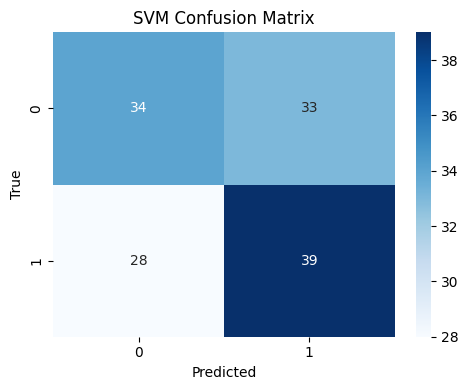

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Load Features -----------
base_path = r""
X_time = np.load(f"{base_path}\\time_features.npy")
X_freq = np.load(f"{base_path}\\freq_features.npy")
y = np.load(f"{base_path}\\labels.npy")

# ----------- Combine Time + Frequency Features -----------
X = np.concatenate([X_time, X_freq], axis=1)

# ----------- Train/Test Split -----------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ----------- Normalize -----------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------- Train SVM -----------
svm = SVC(kernel='linear')  # simpler decision boundary
  # you can try kernel='linear' or 'poly'
svm.fit(X_train, y_train)

# ----------- Predict -----------
y_pred = svm.predict(X_test)

# ----------- Evaluation -----------
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", round(acc * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ----------- Confusion Matrix Plot -----------
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


✅ Accuracy: 55.22 %

Confusion Matrix:
 [[37 30]
 [30 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55        67
           1       0.55      0.55      0.55        67

    accuracy                           0.55       134
   macro avg       0.55      0.55      0.55       134
weighted avg       0.55      0.55      0.55       134



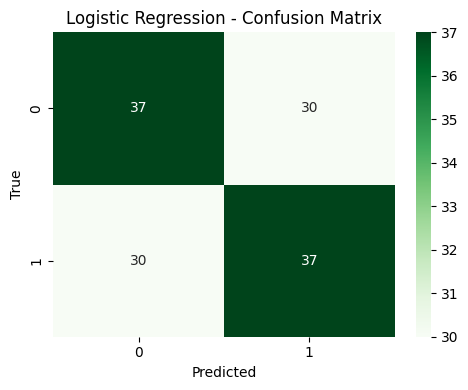

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Load Features -----------
base_path = r""
X_time = np.load(f"{base_path}\\time_features.npy")
X_freq = np.load(f"{base_path}\\freq_features.npy")
y = np.load(f"{base_path}\\labels.npy")

# ----------- Combine Time + Frequency Features -----------
X = np.concatenate([X_time, X_freq], axis=1)

# ----------- Train/Test Split -----------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ----------- Normalize -----------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------- Train Logistic Regression -----------
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# ----------- Predict -----------
y_pred = logreg.predict(X_test)

# ----------- Evaluation -----------
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", round(acc * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ----------- Confusion Matrix Plot -----------
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


LSTM input shape: (662, 5, 1312)


c:\Users\hari7\qiskit_new_env2\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │       352,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,625 (1.35 MB)

 Trainable params: 354,625 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5626 - loss: 0.6807 - val_accuracy: 0.7642 - val_loss: 0.6198
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7858 - loss: 0.5831 - val_accuracy: 0.7830 - val_loss: 0.5661
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8678 - loss: 0.4815 - val_accuracy: 0.8585 - val_loss: 0.4845
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9459 - loss: 0.3500 - val_accuracy: 0.8679 - val_loss: 0.3758
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9725 - loss: 0.2274 - val_accuracy: 0.8868 - val_loss: 0.2823
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9759 - loss: 0.1456 - val_accuracy: 0.9057 - val_loss: 0.2282
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9765 - loss: 0.0999 - val_accuracy: 0.9151 - val_loss: 0.1827
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0530 - val_accuracy: 0.9340 - val_loss

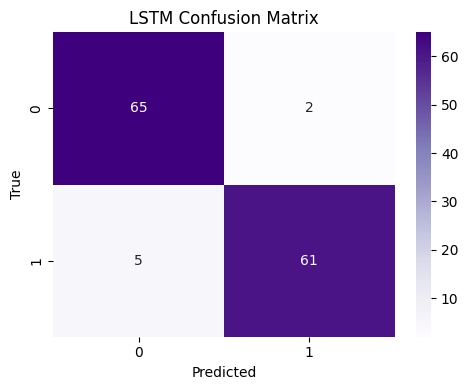

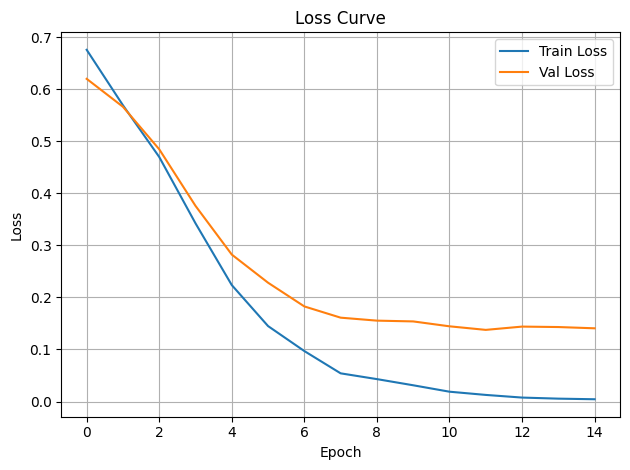

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ========== Load Features ==========
base_path = r""
X_time = np.load(f"{base_path}\\time_features.npy")
X_freq = np.load(f"{base_path}\\freq_features.npy")
y = np.load(f"{base_path}\\labels.npy")

# ========== Combine and Normalize ==========
X = np.concatenate([X_time, X_freq], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ========== Reshape to LSTM Format ==========
# e.g., group every 5 windows → sequence of length 5
SEQ_LEN = 5
num_samples = len(X) - SEQ_LEN + 1

X_seq = []
y_seq = []

for i in range(num_samples):
    seq = X[i:i+SEQ_LEN]
    label = y[i+SEQ_LEN-1]  # use label of last segment
    X_seq.append(seq)
    y_seq.append(label)

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("LSTM input shape:", X_seq.shape)  # (samples, timesteps, features)

# ========== Train/Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# ========== LSTM Model ==========
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ========== Train ==========
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# ========== Evaluate ==========
y_pred = model.predict(X_test).flatten()
y_pred_class = (y_pred > 0.5).astype(int)

print("\n✅ Accuracy:", accuracy_score(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

# ========== Confusion Matrix ==========
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt='d', cmap='Purples')
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ========== Plot Loss ==========
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
